<a href="https://colab.research.google.com/github/arnavrast/pyCboc/blob/master/Santander_Value_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

In [1]:
#!pip install kaggle
!pip install scikit-learn==0.23.1
!pip install scikit-optimize
!pip install pymrmre
!mkdir $HOME/.kaggle
from google.colab import files
uploaded = files.upload()

  Created wheel for pymrmre: filename=pymrmre-1.0.7-cp37-cp37m-linux_x86_64.whl size=323703 sha256=0c7268ada96b9a9e59f4ffa220defaa37533040e4057a659d444a306bf6180d6
  Stored in directory: /root/.cache/pip/wheels/53/c5/4d/b63d3519b91ebfc798ad7e11886e887eed7ebb123d854147d5
Successfully built pymrmre


Saving kaggle.json to kaggle.json


In [2]:
!mv kaggle.json $HOME/.kaggle/kaggle.json
!chmod 600 $HOME/.kaggle/kaggle.json
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!kaggle competitions download -c santander-value-prediction-challenge

User uploaded file "kaggle.json" with length 69 bytes
 72% 5.00M/6.95M [00:00<00:00, 33.3MB/s]
100% 6.95M/6.95M [00:00<00:00, 34.1MB/s]
  0% 0.00/266k [00:00<?, ?B/s]
100% 266k/266k [00:00<00:00, 106MB/s]
 70% 17.0M/24.2M [00:00<00:00, 42.7MB/s]
100% 24.2M/24.2M [00:00<00:00, 54.7MB/s]


# **The Challenge**


According to Epsilon research, 80% of customers are more likely to do business with you if you provide personalized service. Banking is no exception.

The digitalization of everyday lives means that customers expect services to be delivered in a personalized and timely manner… and often before they´ve even realized they need the service. In their 3rd Kaggle competition, Santander Group aims to go a step beyond recognizing that there is a need to provide a customer a financial service and intends to determine the amount or value of the customer's transaction. This means anticipating customer needs in a more concrete, but also simple and personal way. With so many choices for financial services, this need is greater now than ever before.

In this competition, Santander Group is asking Kagglers to help them identify the value of transactions for each potential customer. This is a first step that Santander needs to nail in order to personalize their services at scale.
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as

$$\epsilon=\sqrt{\frac{1}{n}\sum_{i=1}^{n}[log(p_i+1)-log(a_i+1)]^2}$$
Where:

\\(\epsilon\\) is the RMSLE value (score)

\\(n\\) is the total number of observations in the (public/private) data set,

\\(p_i\\) is your prediction of target, and

\\(a_i\\) is the actual target for \\(i\\).

\\(\log(x)\\) is the natural logarithm of \\(x\\)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.sparse import csr_matrix

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn import random_projection
from lightgbm import LGBMRegressor
from sklearn.preprocessing import FunctionTransformer,MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.metrics import make_scorer,mean_squared_error
from pymrmre import mrmr

import gc
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import *
InteractiveShell.ast_node_interactivity = "all"

In [4]:
train= pd.read_csv('/content/train.csv.zip')

In [5]:
print('\n Shape = ',train.shape) #,test.shape
train.info()
train.describe()


 Shape =  (4459, 4993)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,822e49b95,...,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,...,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00
mean,5944923.32,14654.93,1390.89,26722.45,4530.16,26409.96,30708.11,16865.22,4669.21,2569407.37,155215.84,195050.00,8.52,3595.87,2258014.80,268084.32,45882.55,44514.78,396896.09,28831.29,1940.79,448384.09,79897.29,154839.43,112825.36,114832.92,3377.44,0.00,379413.01,120224.71,742646.40,4994.84,1725258.22,194188.17,0.00,93383.27,629689.62,0.00,1249545.29,1200041.53,...,2412.20,376758.91,666947.78,42819.49,6.28,140911.19,236477.99,762748.51,675263.96,542865.36,777697.87,100485.12,382502.49,2539.58,3767.66,41538.91,70412.24,96485.62,975124.02,29109.67,75998.02,3588.25,179601.61,530280.99,237739.63,1183135.48,1247793.15,986.77,61650.15,128949.46,467605.70,444623.94,805621.95,781296.64,143.53,121380.93,35734.51,312374.07,92199.60,227909.96
std,8234311.50,389329.81,64283.02,569965.18,235912.41,1514730.15,577058.97,751275.59,187944.89,9610183.07,1587814.71,2397372.09,569.07,124543.50,15522980.13,3026909.74,814067.36,1354504.11,3238242.60,570538.76,27860.22,6370643.86,2846439.90,2425793.87,1161274.59,2747534.58,131383.85,0.00,3561409.05,4867502.88,3799941.04,186866.36,9034308.14,1481349.06,0.00,854776.37,6956379.91,0.00,7361172.67,8113234.07,...,149858.56,7755050.84,6261372.65,547336.96,322.56,2052878.49,1533061.99,5816721.55,7444468.36,4250171.64,4287642.81,915006.75,2799847.78,150868.32,251588.36,1179500.40,2810829.54,1114863.17,9750283.16,791206.38,1206580.86,239607.96,1660884.12,4497566.80,4109064.67,11394925.26,6878894.51,65892.19,2124731.41,1335938.24,4068037.55,4428889.45,4513245.79,6839450.76,9584.32,4720708.53,1614622.20,4318500.71,1635993.43,1811139.28
min,30000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,600000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2260000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

In [6]:
train_stat = train.agg(['nunique','sum','var','kurtosis','std','min','max','skew']).T
train_stat['Null']=train.isnull().sum()
train_stat['Zeros']=(train==0).sum()
train_stat['Duplicated']=train.T.duplicated()
train_stat['Missing']=1.0*train_stat.Zeros/train.shape[0]

In [7]:
print('Null Values:',train_stat.Null.sum())
print('Zero Values:',train_stat.Zeros.sum())
print('Constant Valued Columns:',np.sum(train_stat['nunique']==1))
print('Zeroed Valued Columns:',len(train_stat[train_stat.Zeros==train.shape[0]]))
print('Duplicated Columns:',train_stat['Duplicated'].sum())

Null Values: 0
Zero Values: 21554760
Constant Valued Columns: 256
Zeroed Valued Columns: 256
Duplicated Columns: 260


In [8]:
HTML('<p>The dataset has <b>'+str(np.sum(train.duplicated()))+' duplicate</b> Records.')

In [9]:
train.pop('ID');

#Sparsity and other characteristics

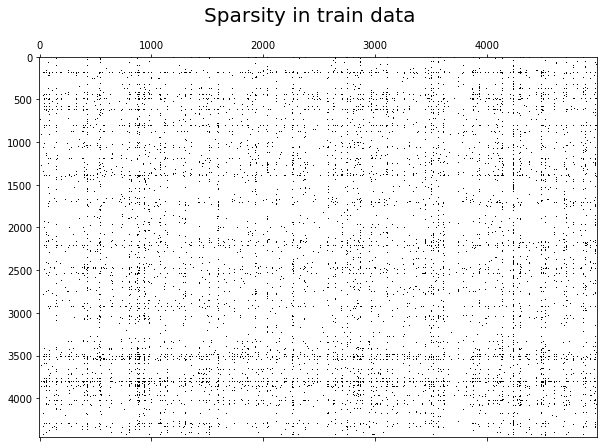

In [10]:
plt.figure(figsize=(10,7));
plt.spy(train,aspect='auto');
plt.suptitle('Sparsity in train data',fontsize=20);

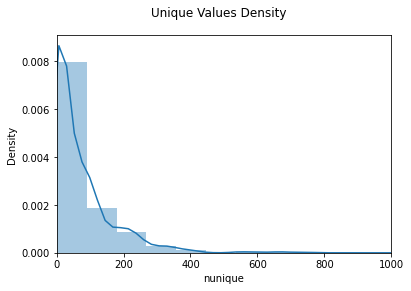

In [11]:
sns.distplot(train_stat['nunique']);
plt.xlim(0,1000);
plt.suptitle('Unique Values Density');

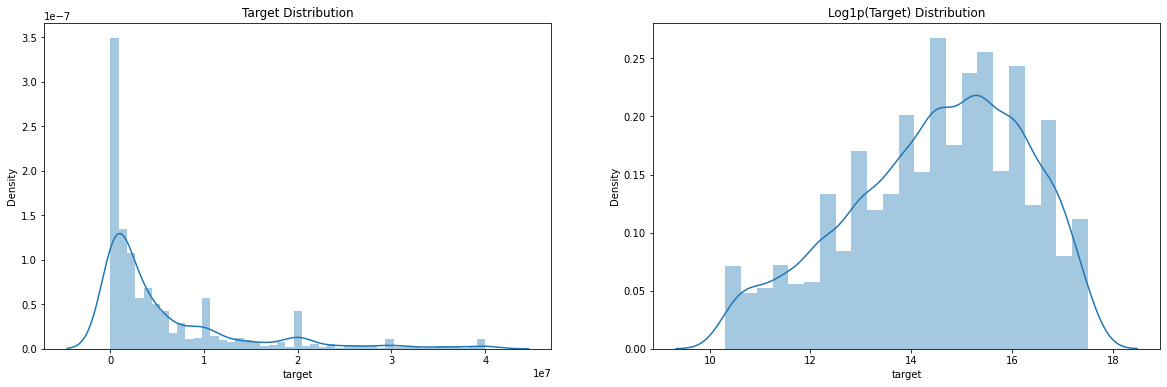

In [12]:
fig, axs = plt.subplots(1,2,figsize=(20,6))
sns.distplot(train.target,ax=axs[0]);
sns.distplot(np.log1p(train.target),ax=axs[1]);
axs[0].title.set_text('Target Distribution');
axs[1].title.set_text('Log1p(Target) Distribution');

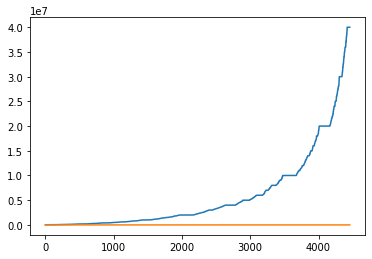

In [13]:
sns.lineplot(data=train ,x=range(train.shape[0]), y=np.sort(train.target));
sns.lineplot(data=train ,x=range(train.shape[0]), y=np.sort(np.log1p(train.target)));

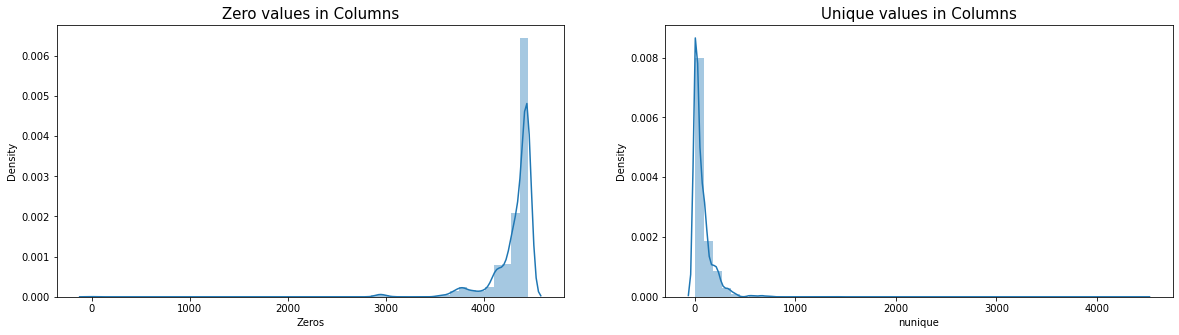

In [14]:
f,ax= plt.subplots(1,2,figsize=(20,5));
sns.distplot(train_stat.Zeros,ax=ax[0]);
sns.distplot(train_stat['nunique'],ax=ax[1]);
ax[0].set_title('Zero values in Columns',fontsize=15);
ax[1].set_title('Unique values in Columns',fontsize=15);

# **Feature Selection & Engineering**

In [15]:
dup_cols = train.columns[train.T.duplicated()]
const_cols=train.columns[train.nunique()==1]
cols_to_remove = dup_cols.append(const_cols).unique()

In [16]:
train.drop(columns=cols_to_remove,inplace=True)
X = train.copy()
Y= pd.DataFrame(np.log1p(X.pop('target')),index=train.index)
X = pd.DataFrame(FunctionTransformer(np.sqrt).fit_transform(X),columns=X.columns,index=X.index)
X = pd.DataFrame(MinMaxScaler().fit_transform(X),columns=X.columns,index=X.index)
solutions = mrmr.mrmr_ensemble(features=X,targets=Y,solution_length=50,solution_count=1)
feat_mrmr=solutions[0][0]
X_freg= SelectKBest(f_regression,k=50).fit(X,Y)
feat_freg=X_freg.get_support()
feat_freg = X.columns[feat_freg]

In [17]:
X_mut= SelectKBest(mutual_info_regression,k=50).fit(csr_matrix(X),Y)
feat_mut=X_mut.get_support()
feat_mut = X.columns[feat_mut]
feat_final = feat_mut.append(pd.Index(feat_mrmr)).append(feat_freg).unique() 
#.append(pd.Index(['9306da53f','fb0f5dbfe']))

In [18]:
def stat_cols(df):
  weight = ((df != 0).sum()/len(df)).values
  df1 = pd.DataFrame()
  df_tmp= df[df!=0]
  df1["sum"] = df.sum(axis=1)
  df1["Values"]=(df!=0).sum(axis=1)
  df1["weight_count"] = (df_tmp*weight).sum(axis=1)
  df1["Variance_NonZero"]=df_tmp.var(axis=1)
  df1["Mean_NonZero"]=df_tmp.mean(axis=1)
  df1["Median_NonZero"]=df_tmp.median(axis=1)
  df1["Std_Dev_NonZero"]=df_tmp.std(axis=1)
  df1["Skew_NonZero"]=df_tmp.skew(axis=1)
  df1["Kurt_NonZero"]=df_tmp.kurtosis(axis=1)
  df1["Max_NonZero"]=df_tmp.max(axis=1)
  df1["Min_NonZero"]=df_tmp.min(axis=1)
  del df_tmp
  gc.collect()
  return df1

def proj_cols(df,n_dim):
  r= random_projection.SparseRandomProjection(n_components=n_dim)
  return pd.DataFrame(r.fit_transform(df)),r

In [19]:
reg=LGBMRegressor(objective='regression_l2',n_jobs=-1,metric='rmse',verbosity=2,boosting='gbdt')
params = {
        'n_estimators': Integer(10, 200),  
        'num_leaves':   Integer(2,100),     
        'min_child_samples': Integer(1, 50), 
        'feature_fraction': Real(0.1, 1.0),
        'max_depth' : Integer(1, 50),
        'learning_rate': Real(0.01, 0.6, 'log-uniform'),
        'reg_lambda': Real(1e-6, 100, 'log-uniform'),
        'scale_pos_weight': Real(1, 10),
        'max_bin': Integer(100, 1000),        
        'min_child_weight': Real(1, 10),      
        'subsample_for_bin': Integer(10, 3000)  
        }


In [20]:
bayes_cv_tuner = BayesSearchCV(
                              estimator = reg,
                              search_spaces = params,
                              cv = 5,
                              n_jobs = 3,
                              n_iter = 10,
                              verbose = 3,
                              random_state = 0
                               )

In [24]:
X = train.copy()[feat_final]
y=np.log1p(train.pop('target'))
rp,r=proj_cols(train,127)
ft=FunctionTransformer(np.sqrt).fit(X)
X_ = pd.DataFrame(ft.transform(X),columns=X.columns)
X_ =pd.concat([X_,stat_cols(train),rp],axis=1)
minmax = MinMaxScaler().fit(X_)
X_ = minmax.transform(X_)
X_=csr_matrix(X_)
result= bayes_cv_tuner.fit(X_,y)
print(bayes_cv_tuner.best_params_)
print("Best Score = ",np.round(bayes_cv_tuner.best_score_, 4))

bst_stat = bayes_cv_tuner.best_estimator_
bst_stat 
np.sqrt(mean_squared_error(y,bst_stat.predict(X_)))

NameError: ignored

In [22]:
#del Z
cols_to_remove
feat_final
r
ft
minmax
del X
del X_
del rp
del train
del train_stat
gc.collect()

Index(['c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7',
       '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d',
       ...
       'a8e562e8e', 'eb6bb7ce1', '5beff147e', '52b347cdc', '4600aadcf',
       '6fa0b9dab', '43d70cc4d', '408021ef8', 'e29d22b59', 'd5308d8bc'],
      dtype='object', length=261)

Index(['20aa07010', '963a49cdc', '68a945b18', '935ca66a9', '861076e21',
       '26fc93eb7', '0572565c2', '66ace2992', '350473311', 'fb49e4212',
       ...
       'fb0f5dbfe', 'd5fa73ead', 'e1d0e11b5', 'ba4ceabc5', '2e103d632',
       'c928b4b74', '122c135ed', 'aeff360c7', '0d51722ca', '555f18bd3'],
      dtype='object', length=107)

SparseRandomProjection(n_components=127)

FunctionTransformer(func=<ufunc 'sqrt'>)

MinMaxScaler()

700

In [ ]:
h=True
for i in range(15):
  test=pd.read_csv('/content/test.csv.zip',skiprows=range(1,i*40000+1),nrows=40000)
  test.drop(columns=cols_to_remove,inplace=True)
  X = test[feat_final]
  rp = pd.DataFrame(r.transform(test.drop(columns=['ID'])))
  st = stat_cols(test.drop(columns=['ID']))
  X_ = pd.DataFrame(ft.transform(X),columns=X.columns)
  X_ =pd.concat([X_,st,rp],axis=1)
  X_ = minmax.transform(X_)
  X_=csr_matrix(X_)
  test['target']=np.expm1(bst_stat.predict(X_))
  del rp
  del X
  del X_
  gc.collect()
  test[['ID', 'target']].to_csv('submission_rp_ft_bayes_lgb.csv', index=False,mode='a',header=h)
  h=False